In [18]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import flax

import tensorflow as tf
import tensorflow_datasets as tfds

In [19]:
mnist = tfds.load("mnist")

def make_dataset(batch_size, seed=1):

    def _preprocess(sample):
        # Convert to floats in [0, 1].
        image = tf.image.convert_image_dtype(sample["image"], tf.float32)
        # Scale the data to [-1, 1] to stabilize training.
        return 2.0 * image - 1.0

    ds = mnist["train"]
    ds = ds.map(map_func=_preprocess,
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # ds = ds.cache()
    ds = ds.shuffle(10 * batch_size, seed=seed).repeat().batch(batch_size)
    return iter(tfds.as_numpy(ds))

# Make the dataset.
dataset = make_dataset(batch_size=4)

In [20]:
class Generator(flax.nn.Module):
    def apply(self, z):
        x = flax.nn.Dense(z, features=7*7*64)
        x = jnp.reshape(x, [x.shape[0], 7, 7, 64])
        x = flax.nn.relu(x)
        x = flax.nn.ConvTranspose(
            x, features=32, kernel_size=(5, 5), strides=(2, 2), padding='SAME')
        x = flax.nn.relu(x)
        x = flax.nn.ConvTranspose(
            x, features=1, kernel_size=(5, 5), strides=(2, 2), padding='SAME')

        x = jnp.tanh(x)

        return x


class Discriminator(flax.nn.Module):
    def apply(self, x):
        x = flax.nn.Conv(x, features=8, kernel_size=(5, 5),
                         strides=(2, 2), padding='SAME')
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = flax.nn.Conv(x, features=16, kernel_size=(5, 5),
                         strides=(1, 1), padding='SAME')
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = flax.nn.Conv(x, features=32, kernel_size=(5, 5),
                         strides=(2, 2), padding='SAME')
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = flax.nn.Conv(x, features=64, kernel_size=(5, 5),
                         strides=(1, 1), padding='SAME')
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = flax.nn.Conv(x, features=128, kernel_size=(5, 5),
                         strides=(2, 2), padding='SAME')
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = jnp.reshape(x, [x.shape[0], -1])

        x = flax.nn.Dense(x, features=2)

        return x


In [21]:
batch = next(dataset)

In [22]:
rng = jax.random.PRNGKey(42)
rng, rng1 = jax.random.split(rng)

In [23]:
  _, initial_params_g = Generator.init_by_shape(rng1, [((1, 20), jnp.float32)])
  generator = flax.nn.Model(Generator, initial_params_g)

In [24]:
  _, initial_params_d = Discriminator.init_by_shape(rng1, [((1, 28, 28, 1), jnp.float32)])
  discriminator = flax.nn.Model(Discriminator, initial_params_d)

In [25]:
optimizer_g = flax.optim.Adam(learning_rate=1e-4, beta1=0.5, beta2=0.9).create(generator)
optimizer_d = flax.optim.Adam(learning_rate=1e-4, beta1=0.5, beta2=0.9).create(discriminator)

In [26]:
@jax.vmap
def sparse_softmax_cross_entropy(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, logits.shape[-1])
    return -jnp.sum(one_hot_labels * jax.nn.log_softmax(logits), axis=-1)

In [27]:
def sample(rng, generator, num_samples):
    z = jax.random.normal(rng, shape=(num_samples, 20))
    return generator(z)

In [33]:
@jax.vmap
def loss1(fake_logits):
    fake_probs = jax.nn.softmax(fake_logits)[:, 1]
    loss = jnp.mean(-jnp.log(fake_probs))

    return loss

In [34]:
@jax.jit
def loss_g(generator, discriminator, rng, batch):
    fake_batch = sample(rng, generator, batch.shape[0])

    fake_logits = discriminator(fake_batch)

    return loss1(fake_logits)

In [29]:
@jax.jit
def loss_d(discriminator, generator, rng, batch):
    fake_batch = sample(rng, generator, batch.shape[0])

    real_and_fake_batch = jnp.concatenate([batch, fake_batch], axis=0)
    real_and_fake_logits = discriminator(real_and_fake_batch)
    real_logits, fake_logits = jnp.split(real_and_fake_logits, 2, axis=0)

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    real_loss = sparse_softmax_cross_entropy(real_logits, real_labels)

    fake_labels = jnp.zeros((batch.shape[0],), dtype=jnp.int32)
    fake_loss = sparse_softmax_cross_entropy(fake_logits, fake_labels)

    loss = jnp.mean(real_loss + fake_loss)
    return loss

In [30]:
def train_step(rng, optimizer_g, optimizer_d, batch):
    rng, rng_gen, rng_disc = jax.random.split(rng, 3)

    g_loss, grad_g = jax.value_and_grad(loss_g)(optimizer_g.target, optimizer_d.target, rng, batch)
    optimizer_g = optimizer_g.apply_gradient(grad_g)

    d_loss, grad_d = jax.value_and_grad(loss_d)(optimizer_d.target, optimizer_g.target, rng, batch)
    optimizer_d = optimizer_d.apply_gradient(grad_d)

    return optimizer_g, optimizer_d, d_loss, g_loss, rng

 60%|██████    | 3/5 [00:07<00:10,  5.41s/it]1.4522817
0.7090566
1.4077485
0.69913447
1.3814361
0.6947105
100%|██████████| 5/5 [00:07<00:00,  1.60s/it]
1.3151356
0.69076526
1.2683103
0.6900234


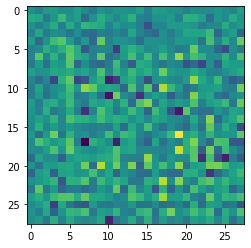

In [31]:
for i in tqdm(range(5)):
    optimizer_g, optimizer_d, d_loss, g_loss, rng = train_step(rng, optimizer_g, optimizer_d, next(dataset))

    if i % 100:
        samples = sample(rng, generator, 1)
        plt.imshow(jnp.reshape(samples, [28, 28]))

    print(d_loss)
    print(g_loss)